### `import` Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import plotly.graph_objects as go

from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification

### Data Preparation

In [2]:
X, y = make_classification(
    n_samples=50000, 
    n_features=15, 
    n_informative=10, 
    n_redundant=5,
    n_classes=2, 
    weights=[0.7], 
    class_sep=0.7, 
    random_state=15
)

In [3]:
def standardize_data_features(data, in_numpy=False):
    data_copy = data.copy()
    
    for col in data_copy.columns:
        mean_val = np.mean(data_copy[col])
        std_dev_val = np.std(data_copy[col])
        data_copy[col] = [(dval - mean_val)/std_dev_val for dval in data_copy[col]]
    
    if not in_numpy:
        return data_copy
    return data_copy.to_numpy()

In [4]:
d = {'col{}'.format(i + 1) : X[:,i] for i in range(len(X[0]))}
df = pd.DataFrame(d)
df = standardize_data_features(data=df)
df['label'] = y

In [5]:
df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,label
0,0.425465,-0.617063,0.106591,-0.886659,-0.408385,-1.568556,0.246499,0.088654,-0.488793,0.583882,-0.097580,-0.324468,-0.517326,-0.050990,-0.362767,0
1,-0.941472,-1.409569,0.040456,0.764539,0.696683,0.147909,1.565954,0.983911,1.252940,-0.143827,-2.225929,1.112467,-1.399473,0.516270,1.220085,0
2,1.961146,-0.254073,-1.418279,1.320003,-1.267539,-1.546825,0.019384,-1.495960,-2.067026,0.658408,1.399561,0.229968,-0.693135,-0.813814,-0.162900,0
3,0.792113,-0.208176,0.880239,0.456642,-0.306181,-0.183526,2.118102,0.457845,1.257053,0.205774,-1.671956,-0.043130,-1.012720,1.508320,0.010328,0
4,0.002884,-1.195057,-1.140043,0.914591,0.429851,-0.157176,0.788740,-0.897764,-0.563314,-1.147905,-1.179350,1.581530,-0.936562,0.767009,-0.095882,0


### Train Test Split

In [6]:
def splitter(dframe, percentage=0.8, random_state=True):
    """
    :param DataFrame dframe: Pandas DataFrame
    :param float percentage: Percentage value to split the data
    :param boolean random_state: True/False
    :return: train_df, test_df
    """
    if random_state:
        dframe = dframe.sample(frac=1)

    thresh = round(len(dframe) * percentage)
    train_df = dframe.iloc[:thresh]
    test_df = dframe.iloc[thresh:]

    return train_df, test_df

In [7]:
train_df, test_df = splitter(dframe=df)

### Custom Logistic Regression

In [8]:
compute_each_loss = lambda yt, yp : (yt*np.log10(yp))+((1-yt)*np.log10(1-yp))

In [9]:
class LogisticRegression():
    def __init__(self, train_df, test_df, label, lambda_=0.0001, eta_rate=0.0001, n_iters=1000):
        self.lambda_ = lambda_
        self.eta_rate = eta_rate
        self.n_iters = n_iters
        
        self.X_train, self.y_train = self.split_features_targets(df=train_df, label=label)
        self.X_test, self.y_test = self.split_features_targets(df=test_df, label=label)
        self.X_train = self.X_train.values
        self.y_train = self.y_train.values
        self.X_test = self.X_test.values
        self.y_test = self.y_test.values
        self.n_ = len(self.X_train)
    
    def split_features_targets(self, df, label):
        X = df.drop(columns=[label], axis=1)
        y = df[label]
        return X, y
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def compute_logloss(self, y_trues, y_preds):
        n = len(y_trues)
        lloss = [compute_each_loss(yt=yt, yp=yp) for (yt, yp) in zip(y_trues, y_preds)]
        return (-1/n) * sum(lloss)
    
    def diff_params_wb(self, x, y, w, b):
        z = np.dot(w.T, x) + b
        w_ = (x * (y - self.sigmoid(z=z))) - (w * (self.lambda_ / self.n_))
        b_ = (y - self.sigmoid(z=z))
        return w_, b_
    
    def predictor(self, X, w, b):
        n = len(X)
        preds = []
        for i in range(n):
            z = np.dot(w, X[i]) + b
            preds.append(self.sigmoid(z))
        return np.array(preds)
    
    def find_best_params(self, show_loss_plot=False):
        ow = np.zeros_like(a=self.X_train[0])
        ob = 0
        
        lloss_train = []
        lloss_test = []
        x_vals = []
        
        for i in tqdm(range(self.n_iters)):
            for xv, yv in zip(self.X_train, self.y_train):
                w_, b_ = self.diff_params_wb(x=xv, y=yv, w=ow, b=ob)
                ow = ((1 - (self.lambda_ * self.eta_rate / self.n_)) * ow) + (self.lambda_ * w_)
                ob = ob + (self.lambda_ * b_)
            
            tr_preds = self.predictor(X=self.X_train, w=ow, b=ob)
            tr_lloss = self.compute_logloss(y_trues=self.y_train, y_preds=tr_preds)
            te_preds = self.predictor(X=self.X_test, w=ow, b=ob)
            te_lloss = self.compute_logloss(y_trues=self.y_test, y_preds=te_preds)
            
            lloss_train.append(tr_lloss)
            lloss_test.append(te_lloss)
            x_vals.append(i)
        
        if show_loss_plot:
            plt.title('Training loss and Testing loss')
            plt.plot(x_vals, lloss_train, 'o-r', label='Training Loss')
            plt.plot(x_vals, lloss_test, 'o-g', label='Testing Loss')
            plt.legend()
            plt.show()
        
        return ow, ob
    
    def predict(self, w, b):
        y_preds = []
        n = len(self.X_test)
        for i in range(n):
            z = np.dot(w, self.X_test[i]) + b
            yp = self.sigmoid(z=z)
            pv = 1 if (yp >= 0.5) else 0
            y_preds.append(pv)
        return y_preds
    
    def score(self, preds):
        preds = np.array(preds)
        if (len(self.y_test) == len(preds)):
            non_z = np.count_nonzero(a=np.where((preds == self.y_test), 1, 0))
            return non_z / len(preds)
        return "Lengths do not match"

### Testing

In [10]:
lr = LogisticRegression(train_df=train_df, test_df=test_df, label='label', n_iters=15)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.41s/it]


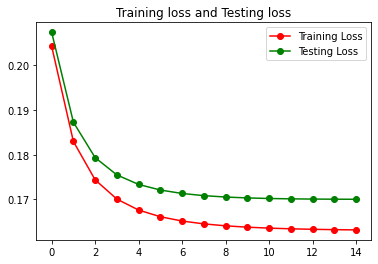

In [11]:
w, b = lr.find_best_params(show_loss_plot=True)

In [12]:
w

array([-0.91828963,  0.65273407, -0.08085585,  0.64507706, -0.40059159,
        0.95296743, -0.92163054, -0.06559788,  0.41769525,  0.43810187,
        0.26098902,  0.04865502, -0.09407813,  0.54129673,  0.07455754])

In [13]:
b

-1.3329452292446695

In [14]:
preds = lr.predict(w=w, b=b)

In [15]:
lr.score(preds=preds)

0.8241

### End